In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/bert-multilingual/bert_multi_from_tfhub/assets/vocab.txt
/kaggle/input/bert-multilingual/b

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time

from sklearn import metrics

import gc

### Configuring TPU's to use in the notebook

In [3]:
# Detect hardware, return appropriate distribution stratergy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU
    
    strategy = tf.distribute.get_strategy()
    
print('Replicas: ', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Replicas:  8


In [4]:
train = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
validation.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [7]:
test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [8]:
# drop columns in train that are not required
train.drop(['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)

In [9]:
print('Size of train', train.shape)
print('Size of validation', validation.shape)
print('Size of test', test.shape)

Size of train (223549, 3)
Size of validation (8000, 4)
Size of test (63812, 3)


Train data size is large. For now, sample a fraction for the dataset, to train the model faster

In [10]:
train_sample = train.sample(12000)
print('Sample train shape', train_sample.shape)

Sample train shape (12000, 3)


Look at the length of the comment to decide on what would be an appropriate length for the sequence

In [11]:
print('Max length of a comment in the input train text is', train_sample['comment_text'].apply(lambda x: len(str(x).split())).max())

Max length of a comment in the input train text is 1250


Looks like keeping a sequence length of 500 should be sufficient

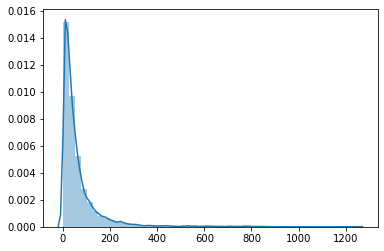

In [12]:
sns.distplot(train_sample['comment_text'].apply(lambda x: len(str(x).split())).values)

Split the train into train, validation tests

In [13]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(train_sample['comment_text'].values, train_sample['toxic'].values, 
                                                    test_size=0.2, random_state=2020,
                                                    stratify = train_sample['toxic'].values)

Using the keras tokenizer here

In [14]:
# Max sequence length
max_len=500

In [15]:
%%time

from keras.preprocessing import text,sequence

keras_tokenizer = text.Tokenizer(num_words = None) # no restriction on number of words to keep, based on word frequency

keras_tokenizer.fit_on_texts(list(xtrain)+ list(xvalid))

# convert to sequences of integers
xtrain_seq = keras_tokenizer.texts_to_sequences(list(xtrain))
xvalid_seq = keras_tokenizer.texts_to_sequences(list(xvalid))

# pad sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen= max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen= max_len)

# getting the word to index mapping based on the frequency
word_index = keras_tokenizer.word_index

Using TensorFlow backend.


CPU times: user 2.24 s, sys: 43.1 ms, total: 2.28 s
Wall time: 2.34 s


### Using a simpe RNN model using keras sequential model

In [16]:
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, GRU, SimpleRNN, LSTM, Bidirectional, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model

In [17]:
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim = len(word_index)+1, output_dim = 300, input_length=max_len))
    model.add(SimpleRNN(units =100))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          13949100  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 13,989,301
Trainable params: 13,989,301
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
%%time
# multiply by strategy to run on TPUs or GPUs

#model.fit(xtrain_pad, ytrain, batch_size= 64 * strategy.num_replicas_in_sync, epochs=3, validation_data=[xvalid_pad, yvalid])
model.fit(xtrain_pad, ytrain, batch_size= 64 * strategy.num_replicas_in_sync, epochs=3)

Epoch 1/3
19/19 [==============================] - 3s 159ms/step - loss: 0.3670 - accuracy: 0.8743
Epoch 2/3
19/19 [==============================] - 1s 32ms/step - loss: 0.2912 - accuracy: 0.9058
Epoch 3/3
19/19 [==============================] - 1s 32ms/step - loss: 0.2399 - accuracy: 0.9073
CPU times: user 3.65 s, sys: 284 ms, total: 3.93 s
Wall time: 10.8 s


In [19]:
prediction = model.predict(xvalid_pad)
print('ROC-AUC score', metrics.roc_auc_score(yvalid, prediction))

ROC-AUC score 0.7814639626804308


In [20]:
%%time
EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'

embedding_index = {}

with open(EMBEDDING_FILE, 'r', encoding='utf8') as fp:
    for line in tqdm(fp):
        values = line.split(' ')
        word = values[0]
        embedding_vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = embedding_vector
        
print('Found {} word vectors', len(embedding_index))        

2196018it [05:35, 6554.65it/s]

Found {} word vectors 2196017
CPU times: user 5min 34s, sys: 17.8 s, total: 5min 52s
Wall time: 5min 35s


### Using LSTM on keras

lets use the glove embeddings in our Embedding layers instead of learning from scratch

In [21]:
%%time

# getting the word embedding for the word in the vocabulary / word_index
# embedding index is the mapping of the word index to the embedding vector

embed_size = 300

embedding_matrix = np.zeros((len(word_index)+1, embed_size))

for word, index in tqdm(word_index.items()):
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print('Found embedding for {} words from the vocabulary'.format(len(word_index)))

100%|██████████| 46496/46496 [00:00<00:00, 170894.54it/s]

Found embedding for 46496 words from the vocabulary
CPU times: user 193 ms, sys: 90.6 ms, total: 283 ms
Wall time: 276 ms


In [22]:
with strategy.scope():
    
    model = Sequential()
    model.add(Embedding(input_dim = len(word_index)+1, output_dim=embed_size,
                       input_length = max_len,
                       weights = [embedding_matrix], trainable=False))
    
    model.add(LSTM(units=100, dropout=0.25, recurrent_dropout=0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          13949100  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 14,109,601
Trainable params: 160,501
Non-trainable params: 13,949,100
_________________________________________________________________
None


In [23]:
%%time
model.fit(xtrain_pad, ytrain, epochs=3, batch_size=64 * strategy.num_replicas_in_sync, validation_data = [xvalid_pad, yvalid])

Epoch 1/3
19/19 [==============================] - 4s 189ms/step - loss: 0.3613 - accuracy: 0.8633 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
19/19 [==============================] - 1s 67ms/step - loss: 0.2439 - accuracy: 0.9170 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/3
19/19 [==============================] - 1s 68ms/step - loss: 0.1848 - accuracy: 0.9308 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
CPU times: user 6.8 s, sys: 386 ms, total: 7.18 s
Wall time: 12.9 s


In [24]:
prediction = model.predict(xvalid_pad)
print('ROC-AUC score with LSTM using glove embeddings is ', metrics.roc_auc_score(yvalid, prediction))

ROC-AUC score with LSTM using glove embeddings is  0.9343162556683574


### Using GRU(Gated Recurrent Units)

GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.

In [25]:
with strategy.scope():
    
    model = Sequential()
    model.add(Embedding(input_dim = len(word_index) + 1, output_dim=embed_size,
                       input_length = max_len,
                       weights = [embedding_matrix], trainable=False))
    
    model.add(SpatialDropout1D(0.25))
    model.add(GRU(units=200))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          13949100  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 300)          0         
_________________________________________________________________
gru (GRU)                    (None, 200)               301200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 14,250,501
Trainable params: 301,401
Non-trainable params: 13,949,100
_________________________________________________________________
None


In [26]:
%%time
model.fit(xtrain_pad, ytrain, epochs=3, batch_size = 64 * strategy.num_replicas_in_sync)

Epoch 1/3
19/19 [==============================] - 2s 85ms/step - loss: 0.3400 - accuracy: 0.8768
Epoch 2/3
19/19 [==============================] - 1s 33ms/step - loss: 0.2211 - accuracy: 0.9258
Epoch 3/3
19/19 [==============================] - 1s 33ms/step - loss: 0.1649 - accuracy: 0.9429
CPU times: user 3.77 s, sys: 251 ms, total: 4.03 s
Wall time: 8.09 s


In [27]:
prediction = model.predict(xvalid_pad)
print('ROC-AUC score for GRU on glove embedding is', metrics.roc_auc_score(yvalid, prediction))

ROC-AUC score for GRU on glove embedding is 0.9259124325292474


### Using Bidirectional LSTM

In [28]:
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim = len(word_index) + 1, output_dim=embed_size,
                       input_length = max_len,
                       weights = [embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(units=300, dropout =0.25, recurrent_dropout=0.25)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          13949100  
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 601       
Total params: 15,392,101
Trainable params: 1,443,001
Non-trainable params: 13,949,100
_________________________________________________________________
None


In [29]:
%%time
model.fit(xtrain_pad, ytrain, epochs=3, batch_size = 64 * strategy.num_replicas_in_sync)

predicton = model.predict(xvalid_pad)
print('ROC-AUC score for Bidirectional LSTM on glove embedding is', metrics.roc_auc_score(yvalid, prediction))

Epoch 1/3
19/19 [==============================] - 5s 250ms/step - loss: 0.3131 - accuracy: 0.9003
Epoch 2/3
19/19 [==============================] - 3s 148ms/step - loss: 0.1837 - accuracy: 0.9341
Epoch 3/3
19/19 [==============================] - 3s 148ms/step - loss: 0.1480 - accuracy: 0.9464
ROC-AUC score for Bidirectional LSTM on glove embedding is 0.9259124325292474
CPU times: user 7.41 s, sys: 420 ms, total: 7.83 s
Wall time: 22.9 s


In [30]:
gc.collect()

16054

### Using BERT model

The main steps involved here are:
    * Data preparation: tokenization and encoding of data
    * Configuring TPU's
    * Model training and adding an output layer for classification

**Tokenizers** (https://github.com/huggingface/tokenizers)

We will be using the tokenizers from huggingface, which provides an implementation of today's most used tokenizers, with a focus on performance and versatility.

* They are **fast tokenizers** and do all the preprocessing like *truncate*, *pad* and add the *special tokens* the model needs


In [31]:
from tokenizers import BertWordPieceTokenizer
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


### Create the fast tokenizer

In [32]:
# loading the BERT tokenizer

bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# save the model locally

#bert_tokenizer.save_pretrained('.')

bert_fast_tokenizer = BertWordPieceTokenizer('../input/bert-multilingual/bert_multi_from_tfhub/assets/vocab.txt',lowercase=False)
print(bert_fast_tokenizer)


Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)


Using the `tf.data` API. Refer [here](https://www.tensorflow.org/guide/data_performance)

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. *The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. *You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the **tf.data** runtime to tune the value dynamically at runtime.

In [33]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

### Helper functions

In [34]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    
    tokenizer.enable_truncation(max_length = maxlen)
    tokenizer.enable_padding(max_length = maxlen)
    all_ids =[]
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i: i+chunk_size].tolist()
        # encode the chunk of texts
        encode_chunk = tokenizer.encode_batch(text_chunk)
        #use extend to add the chunks to the end of the list
        all_ids.extend([enc.ids for enc in encode_chunk])
        
    
    #print(type(all_ids))
    return np.asarray(all_ids)

In [35]:
%%time

x_train = fast_encode(train['comment_text'].astype('str'), bert_fast_tokenizer, maxlen = MAX_LEN)
x_valid = fast_encode(validation['comment_text'].astype('str'), bert_fast_tokenizer, maxlen = MAX_LEN)
x_test = fast_encode(test['content'].astype('str'), bert_fast_tokenizer, maxlen = MAX_LEN)

100%|██████████| 250/250 [00:10<00:00, 24.26it/s]

CPU times: user 2min 26s, sys: 2.66 s, total: 2min 29s
Wall time: 56.4 s


In [36]:
y_train = train['toxic'].values
y_valid = validation['toxic'].values

**Creating the datasets for BERT**

For more details, refer [here](https://www.tensorflow.org/guide/data)

- .from_tensor_slices() - Creates a Dataset whose elements are slices of the given tensors.The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.

- .shuffle() transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer
- .repeat() - Repeats this dataset so each original value is seen 'count' times or repeat the same datatset for 'n' epochs
- .prefetch() - Creates a Dataset that prefetches elements from this dataset.Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
- .cache() - Caches the elements in this dataset.The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.

In [37]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [38]:
# building the model

def build_model(transformer, max_len = 512):
    
    input_word_ids = Input(shape =(max_len, ), dtype = tf.int32, name = 'input_words')
    sequence_output = transformer(input_word_ids)[0]
    cls_token  = sequence_output[:, 0, :]
    out = Dense(1, activation ='sigmoid')(cls_token)
    
    model = Model(inputs = input_word_ids, outputs = out)
    model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])
    
    return model

In [39]:
with strategy.scope():
    
    # defining the transformer layer
    transformer_layer = (
        transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
                )
    
    model = build_model(transformer_layer, max_len = MAX_LEN)

print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_words (InputLayer)     [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 192, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
%%time

# get the number of steps per epoch
nsteps = x_train.shape[0] // BATCH_SIZE


train_history = model.fit(
                train_dataset,
                steps_per_epoch = nsteps,
                validation_data = valid_dataset,
                epochs = EPOCHS
                )

Epoch 1/3
1746/1746 [==============================] - 177s 101ms/step - loss: 0.1250 - accuracy: 0.9509 - val_loss: 0.4256 - val_accuracy: 0.8495
Epoch 2/3
1746/1746 [==============================] - 166s 95ms/step - loss: 0.0915 - accuracy: 0.9623 - val_loss: 0.4706 - val_accuracy: 0.8499
Epoch 3/3
1746/1746 [==============================] - 166s 95ms/step - loss: 0.0788 - accuracy: 0.9674 - val_loss: 0.4767 - val_accuracy: 0.8511
CPU times: user 1min 27s, sys: 8.18 s, total: 1min 35s
Wall time: 9min 4s


In [41]:
submission = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission

,id,toxic
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
63807,63807,0.5
63808,63808,0.5
63809,63809,0.5
63810,63810,0.5


In [42]:
prediction = model.predict(test_dataset, verbose=1)
submission['toxic'] = prediction

submission.sample(20)

499/499 [==============================] - 16s 33ms/step


,id,toxic
7744,7744,0.008468
27737,27737,0.004970
58731,58731,0.221745
59640,59640,0.006215
36553,36553,0.034163
4295,4295,0.000324
46955,46955,0.000699
61340,61340,0.099451
18816,18816,0.012826
48947,48947,0.025843
